In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
import os.path as osp
import json
from tqdm import  tqdm
import sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('/data/Hszhu/Reggio')
# from simple_lama_inpainting import SimpleLama
# from lama import lama_with_refine
from src.demo.model import AutoPipeReggio
import torch
import cv2
import argparse
from src.utils.attention import AttentionStore,register_attention_control,Mask_Expansion_SELF_ATTN
import clip
from diffusers import StableDiffusionPipeline, DDIMInverseScheduler, AutoencoderKL, DDIMScheduler,DDIMPipeline,StableDiffusionInpaintPipeline,UNet2DConditionModel
def temp_view_img(image: Image.Image, title: str = None) -> None:
    # PIL -> ndarray OR ndarray->PIL->ndarray
    if not isinstance(image, Image.Image):  # ndarray
        # image_array = Image.fromarray(image).convert('RGB')
        image_array = image
    else:  # PIL
        if image.mode != 'RGB':
            image.convert('RGB')
        image_array = np.array(image)

    plt.imshow(image_array)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()
def visualize_rgb_image(image: Image.Image, title: str = None) -> None:
    """
    Visualize an RGB image from a PIL Image format with an optional title.

    Parameters:
    image (PIL.Image.Image): The RGB image represented as a PIL Image.
    title (str, optional): The title to display above the image.

    Raises:
    ValueError: If the input is not a PIL Image or is not in RGB mode.
    """
    if not isinstance(image, Image.Image):
        raise ValueError("Input must be a PIL Image.")
    if image.mode != 'RGB':
        raise ValueError("Input image must be in RGB mode.")

    image_array = np.array(image)

    plt.imshow(image_array)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()
def temp_view( mask, title='Mask', name=None):
    """
    显示输入的mask图像

    参数:
    mask (torch.Tensor): 要显示的mask图像，类型应为torch.bool或torch.float32
    title (str): 图像标题
    """
    # 确保输入的mask是float类型以便于显示
    if isinstance(mask, np.ndarray):
        mask_new = mask
    else:
        mask_new = mask.float()
        mask_new = mask_new.detach().cpu()
        mask_new = mask_new.numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(mask_new, cmap='gray')
    plt.title(title)
    plt.axis('off')  # 去掉坐标轴
    # plt.savefig(name+'.png')
    plt.show()
def replace_mask(mask,src_mask_path):
    # 保存mask到ins子文件夹中
    cv2.imwrite(src_mask_path, mask.astype(np.uint8) * 255)
    print(f"Saved mask to {src_mask_path}")
    return src_mask_path
def save_mask(mask, dst_dir, da_name, ins_name,sample_id):
    da_name = str(da_name)
    ins_name = str(ins_name)
    sample_id = str(sample_id)
    # 创建da子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 创建ins子文件夹
    ins_subfolder_path = os.path.join(subfolder_path, ins_name)
    os.makedirs(ins_subfolder_path, exist_ok=True)

    # 保存mask到ins子文件夹中
    mask_path = os.path.join(ins_subfolder_path, f"{sample_id}.png")
    cv2.imwrite(mask_path, mask.astype(np.uint8)*255)
    print(f"Saved mask to {mask_path}")

    return mask_path
def save_img(img, dst_dir, da_name, ins_name,sample_id):
    da_name = str(da_name)
    ins_name = str(ins_name)
    sample_id = str(sample_id)
    # 创建da子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 创建ins子文件夹
    ins_subfolder_path = os.path.join(subfolder_path, ins_name)
    os.makedirs(ins_subfolder_path, exist_ok=True)

    # 保存img到ins子文件夹中
    img_path = os.path.join(ins_subfolder_path, f"{sample_id}.png")
    cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    print(f"Saved image to {img_path}")

    return img_path

def save_json(data_dict, file_path):
    """
    将字典保存为 JSON 文件

    Args:
        data_dict (dict): 需要保存的字典
        file_path (str): JSON 文件的保存路径
    """
    with open(file_path, 'w', encoding='utf-8') as json_file:
        json.dump(data_dict, json_file, ensure_ascii=False, indent=4)
def save_masks(masks, dst_dir, da_name):
    # 创建子文件夹
    subfolder_path = os.path.join(dst_dir, da_name)
    os.makedirs(subfolder_path, exist_ok=True)

    # 用于存储保存的mask路径
    mask_paths = []

    # 保存每个mask到子文件夹中
    for idx, mask in enumerate(masks):
        mask_path = os.path.join(subfolder_path, f"mask_{idx + 1}.png")
        cv2.imwrite(mask_path, mask)  # 将mask保存为png图片 (注意：mask是二值图，乘以255以得到可见的结果)
        print(f"Saved mask {idx + 1} to {mask_path}")
        mask_paths.append(mask_path)

    return mask_paths
def load_json(file_path):
    """
    加载指定路径的JSON文件并返回数据。

    :param file_path: JSON文件的路径
    :return: 从JSON文件中加载的数据
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        return data
    except FileNotFoundError:
        print(f"文件未找到: {file_path}")
    except json.JSONDecodeError:
        print(f"文件格式错误: {file_path}")
    except Exception as e:
        print(f"加载JSON文件时出错: {e}")
    return None
import random
def split_data(data, num_splits, subset_num=None,seed=None):
    if seed is not None:
        random.seed(seed)
    data_keys = list(data.keys())

    # 如果需要从数据中随机抽取100个
    if subset_num is not None:
        data_keys = random.sample(data_keys, subset_num)  # 随机抽取subset_num个键
    else:
        random.shuffle(data_keys)  # 随机打乱数据键

    chunk_size = len(data_keys) // num_splits
    data_parts = []

    for i in range(num_splits):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i != num_splits - 1 else len(data_keys)
        data_part = {k: data[k] for k in data_keys[start_idx:end_idx]}
        data_parts.append(data_part)

    return data_parts


def get_constrain_areas(mask_list_path):
    mask_list = [cv2.imread(pa) for pa in mask_list_path]
    if len(mask_list)>0:
        constrain_areas = np.zeros_like(mask_list[0])
    for mask in mask_list:
        mask[mask>0] = 1
        constrain_areas +=mask
    constrain_areas[constrain_areas>0] =1
    return constrain_areas[:,:,0]


def prepare_mask_pool(instances):
    mask_pool = []
    for i in range(len(instances)):
        ins = instances[str(i)]
        if len(ins) == 0:
            continue

        # 获取字典的第一个键
        first_key = next(iter(ins))

        # 将第一个键对应的 'ori_mask_path' 添加到 mask_pool
        mask_pool.append(ins[first_key]['ori_mask_path'])

    return mask_pool


# data_parts = split_data(data, 2 , seed=42)


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

pretrained_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-v1-5/"
# vae_path = "default"
# pretrained_inpaint_model_path = "/data/Hszhu/prompt-to-prompt/stable-diffusion-2-inpainting/"

precision=torch.float32
model = AutoPipeReggio.from_pretrained(pretrained_model_path,torch_dtype=precision).to(device)
# if vae_path != "default":
#     model.vae = AutoencoderKL.from_pretrained(
#         vae_path
#     ).to(model.vae.device, model.vae.dtype)

model.scheduler = DDIMScheduler.from_config(model.scheduler.config,)
# model.inpainter = lama_with_refine(device)
controller = Mask_Expansion_SELF_ATTN(block_size=8,drop_rate=0.5,start_layer=10)
controller.contrast_beta = 1.67
controller.use_contrast = True
model.controller = controller
register_attention_control(model, controller)
model.modify_unet_forward()
model.enable_attention_slicing()
model.enable_xformers_memory_efficient_attention()
seed=42
 

/home/hszhu/anaconda3/envs/Reggio2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-08 16:55:48.760642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-08 16:55:48.774023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-08 16:55:48.778140: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 16:55:48.790516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow 

Global seed set to 42


input text embeddings : torch.Size([2, 77, 768])


DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 12.93it/s]


leng latent inv 38
shape latent:torch.Size([2, 4, 64, 64])


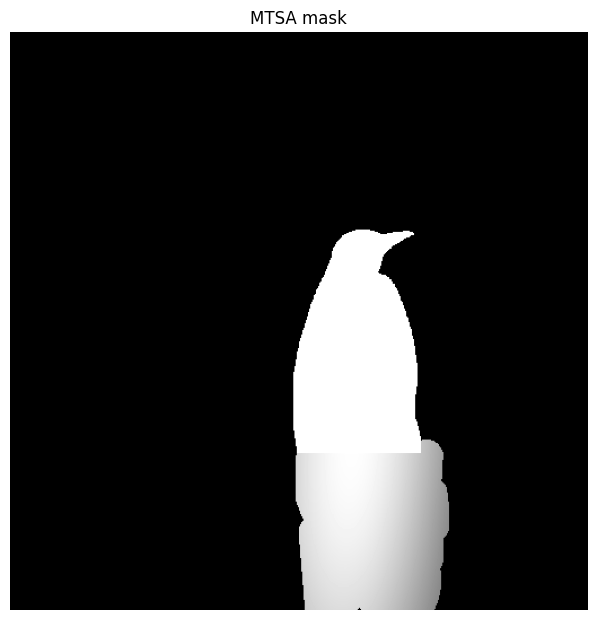

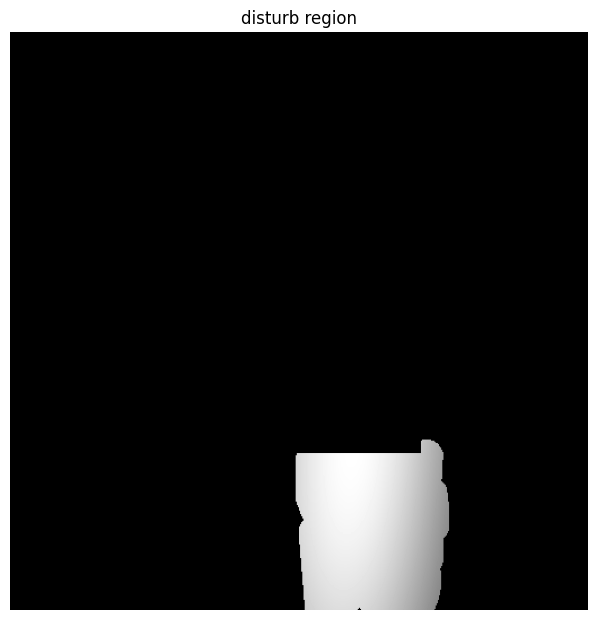

input text embeddings : torch.Size([2, 77, 768])
latents shape:  torch.Size([2, 4, 64, 64])


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.01it/s]


ori
penguin
coarse
gen


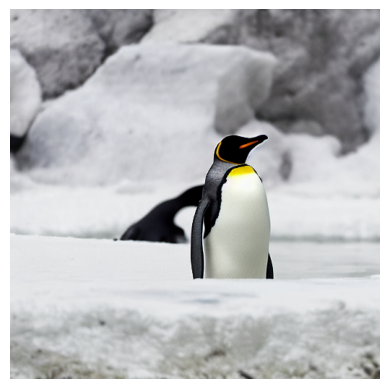

penguin


In [6]:
data = load_json("/data/Hszhu/dataset/PIE-Bench_v1/Subset_0/coarse_input_full_pack_0.json")
da_n = '27'
da = data[da_n]
instances = da['instances']
edit_meta = instances['0']
coarse_input_pack = edit_meta['0']
mask_pool = prepare_mask_pool(instances)
# constrain_areas_strict = get_constrain_areas(mask_pool)
# constrain_areas_strict  = cv2.resize(constrain_areas_strict , dsize=(512,512), interpolation=cv2.INTER_NEAREST)

edit_prompt = coarse_input_pack['edit_prompt']
ori_img = cv2.imread(coarse_input_pack['src_img_path'])  # bgr
ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
# temp_view_img(ori_img)
# ori_caption  = coarse_input_pack['tag_caption']
ori_mask = cv2.imread(coarse_input_pack['ori_mask_path'])
obj_label = coarse_input_pack['obj_label']
target_mask = cv2.imread(coarse_input_pack['tgt_mask_path'])
# ddpm_region_mask =  cv2.imread(coarse_input_pack['ddpm_region_path'])
coarse_input = cv2.imread(coarse_input_pack['coarse_input_path'])  # bgr
coarse_input = cv2.cvtColor( coarse_input , cv2.COLOR_BGR2RGB)
ori_mask = cv2.resize(ori_mask,dsize = target_mask.shape[:2],interpolation=cv2.INTER_NEAREST)

# generated_results,exp_target_mask = model.generated_refine_results(ori_img,ori_mask,coarse_input,target_mask,constrain_areas_strict,obj_label,guidance_scale=7.5,eta=1.0,contrast_beta = 1.67,
#                                                    end_step = 0, num_step = 50, start_step = 25,use_mtsa = True,feature_injection=False,local_text_edit=True,local_ddpm=True,verbose=True, obj_label= obj_label)#add gen_res in input_pack
# 
# generated_results = model.Reggio_refine_generation_gs(ori_img, ori_mask, coarse_input,
#                                                                         target_mask, constrain_areas_strict,
#                                                                         obj_label, guidance_scale=1.1,
#                                                                         eta=0.7, contrast_beta=1.67,
#                                                                         end_step=0, num_step=50,
#                                                                         start_step=12, use_mtsa=True,
#                                                                         local_text_edit=False,
#                                                                         local_ddpm=True, verbose=False,
#                                                                         return_ori=False,use_gs=True,gs_scale=0.4,gs_bond_scale=0.4,seed=42)  # add gen_res in input_pack
draw_mask =  cv2.imread("/data/Hszhu/Reggio/data_gen_utils/draw_mask.png") 
# obj_label = ""
seed = 42
generated_results = model.Reggio_refine_generation(ori_img, ori_mask, coarse_input,
                                                                            target_mask,
                                                                            obj_label, guidance_scale=7.5,
                                                                            eta=0.0, contrast_beta=1.67,
                                                                            end_step=0, num_step=50,
                                                                            start_step=13, use_mtsa=False,
                                                                            local_text_edit=False,
                                                                            local_ddpm=False, verbose=False,
                                                                            return_ori=False,seed=seed,draw_mask=draw_mask,
                                                                           use_gs=True, gs_scale=1.5,
                                                                           return_intermediates=True, )  # add gen_res in input_pack
   
gen_image = Image.fromarray(generated_results)
# ref_image = Image.fromarray(gen_ori_results)
print('ori')
# temp_view_img(ori_img)
print(obj_label)
print('coarse')
# temp_view_img(coarse_input)
print('gen')
temp_view_img(gen_image)
print(obj_label)


In [ ]:
generated_results,gen_ori_results = model.generated_refine_results(ori_img, ori_mask, coarse_input,
                                                                    target_mask, constrain_areas_strict,
                                                                    obj_label, guidance_scale=7.5,
                                                                    eta=0.0, contrast_beta=1.67,
                                                                    end_step=0, num_step=100,
                                                                    start_step=25, use_mtsa=True,
                                                                    feature_injection=False,
                                                                    local_text_edit=True,
                                                                    local_ddpm=True, verbose=True,
                                                                    return_ori=True)  # add gen_res in input_pack

gen_image = Image.fromarray(generated_results)
ref_image = Image.fromarray(gen_ori_results)
# temp_view_img(ori_img)
# print(obj_label)
# temp_view_img(coarse_input)
temp_view_img(gen_image)